# Feature Engineering

In [1]:
# importacion general de librerias y de visualizacion (matplotlib y seaborn)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

import warnings
warnings.filterwarnings('ignore')

In [2]:
from scipy.stats.mstats import winsorize

## Carga de datos

Se cargan las columnas con formatos adecuados según el tipo de datos.  
Se usa como índice building_id para train_values y train_labels  

In [3]:
# Train values
# Levantar los datos de cada edificio/casa
df = pd.read_csv('datos/train_values.csv',nrows=0)
columnas = df.columns.to_list()
datatypes = {
    **{columnas[0]:np.int32}\
    , **{column:np.int16 for column in columnas[1:8] + columnas[27:28]}\
    , **{column:'category' for column in columnas[8:15] + columnas[26:27]}\
    , **{column:np.bool for column in columnas[15:26] + columnas[28:39]}
}
train_values = pd.read_csv('datos/train_values.csv',dtype=datatypes)
train_values = train_values.set_index("building_id")
columnas = train_values.columns.to_list()

In [4]:
#Train labels
train_labels = pd.read_csv('datos/train_labels.csv',index_col='building_id')

## Información de los datasets

In [5]:
train_values.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 38 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          260601 non-null  int16   
 1   geo_level_2_id                          260601 non-null  int16   
 2   geo_level_3_id                          260601 non-null  int16   
 3   count_floors_pre_eq                     260601 non-null  int16   
 4   age                                     260601 non-null  int16   
 5   area_percentage                         260601 non-null  int16   
 6   height_percentage                       260601 non-null  int16   
 7   land_surface_condition                  260601 non-null  category
 8   foundation_type                         260601 non-null  category
 9   roof_type                               260601 non-null  category
 10  ground_floor_type          

In [6]:
train_values.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,...,False,False,False,False,False,False,False,False,False,False
28830,8,900,2812,2,10,8,7,o,r,n,...,False,False,False,False,False,False,False,False,False,False
94947,21,363,8973,2,10,5,5,t,r,n,...,False,False,False,False,False,False,False,False,False,False
590882,22,418,10694,2,10,6,5,t,r,n,...,False,False,False,False,False,False,False,False,False,False
201944,11,131,1488,3,30,8,9,t,r,n,...,False,False,False,False,False,False,False,False,False,False


In [7]:
train_labels.head()

,damage_grade
building_id,
802906,3
28830,2
94947,3
590882,2
201944,3


## Feature Importance

Utilicemos Random Forest para ver la importancia de los features  
Importamos lo necesario para correr Random Forest

In [55]:
# Para ver los parametros que se utilizan
from pprint import pprint
import pickle

Usando XGBOOST

In [56]:
#Se obtiene de correr con XGBoost todos los features y max depth 10
filename = 'modelos/xgb_modelo_inicial.sav'

In [57]:
loaded_model = pickle.load(open(filename, 'rb'))

In [58]:
#loaded_model = xgb_model

In [59]:
feature_important = loaded_model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)

El modelo se entreno con todos los features y get_dummies

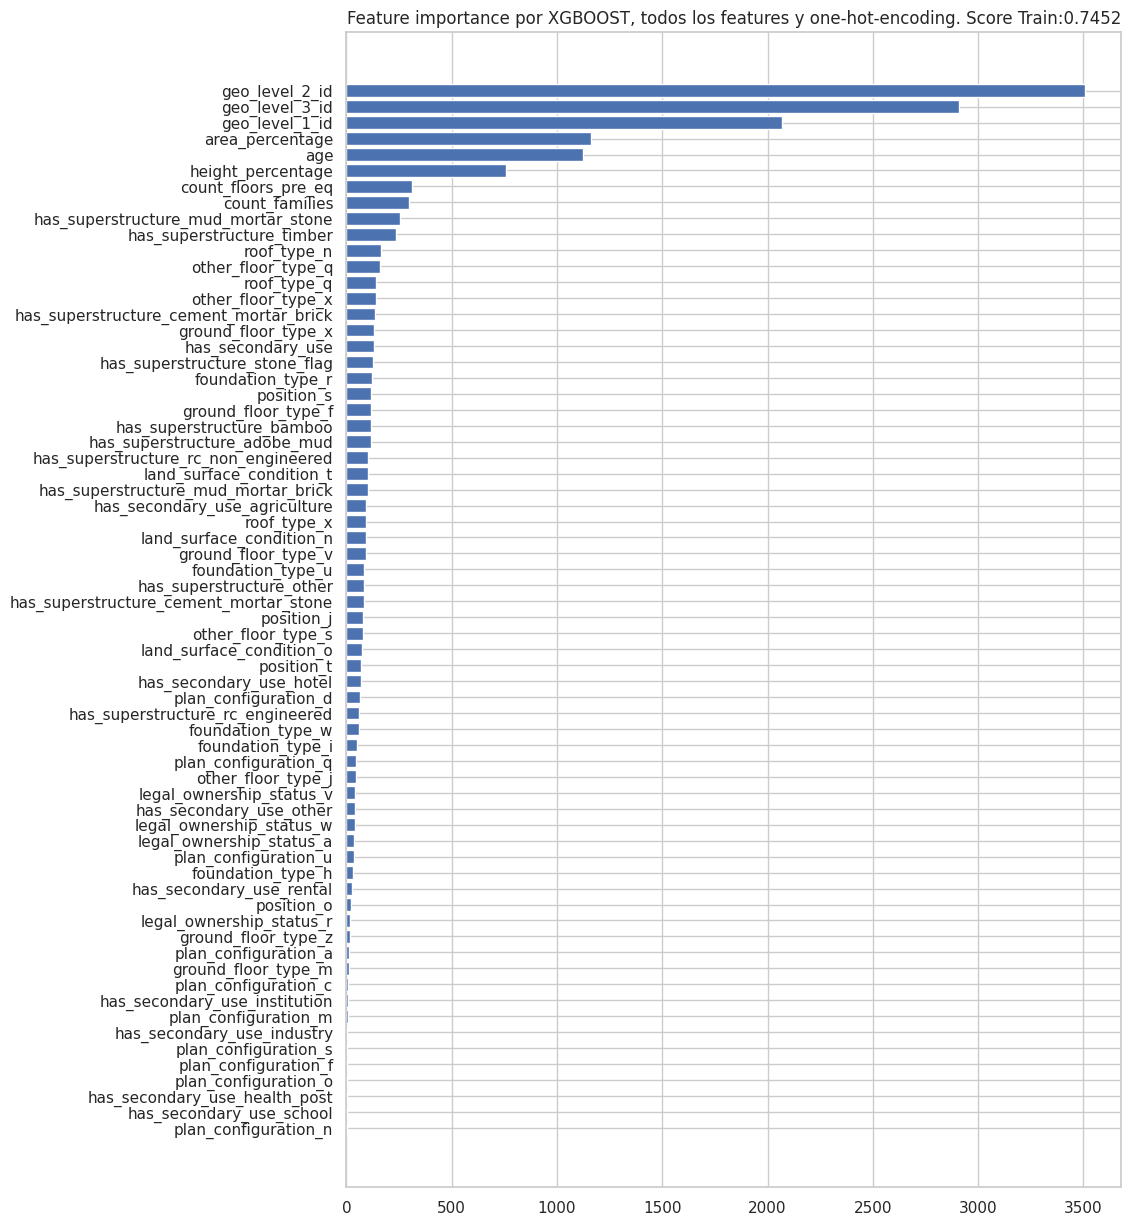

In [12]:
#Grafico de feature importance
fig, ax = plt.subplots(figsize=(10,15))
ax.barh(data.index,data['score'].values)
ax.set_title('Feature importance por XGBOOST, todos los features y one-hot-encoding. Score Train:0.7452')
plt.show()

## Conclusiones de Feature importance

*  Las variantes has_secondary_use tienen muy poca importancia para XGBoost. Nos podemos quedar solo con la de has_secondary_use a secas.
*  Plan_configuration es el que lo sigue en menor importancia para el algoritmo. Considerar una transformación apropiada. "Si está alquilada->la cuidan menos->más deteriorada está->más riesgo de derrumbe ?)"
*  El resto es analizar columna por columna.

In [13]:
# Elimino las variantes de has_secondary_use
train_values_base = train_values.iloc[:,:28]
# Dropeo legal_ownership_status. No sirve para el algoritmo. ¿Reemplazar?
train_values_base = train_values_base.drop(labels='legal_ownership_status',axis=1)

In [14]:
train_values_base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 27 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          260601 non-null  int16   
 1   geo_level_2_id                          260601 non-null  int16   
 2   geo_level_3_id                          260601 non-null  int16   
 3   count_floors_pre_eq                     260601 non-null  int16   
 4   age                                     260601 non-null  int16   
 5   area_percentage                         260601 non-null  int16   
 6   height_percentage                       260601 non-null  int16   
 7   land_surface_condition                  260601 non-null  category
 8   foundation_type                         260601 non-null  category
 9   roof_type                               260601 non-null  category
 10  ground_floor_type          

## Analisis columna por columna

## Geo Level Id (todavia no hice nada sobre esto)

Analizar para los geo_level_id que más daño sufrieron cuales son las características más importantes y se puede hacer un feature booleano.  
Podemos hacer mean encoding y poner el porcentaje de esa ciudad.  
Por ejemplo para todos los que pertenezcan al geo_level_id_1 "17", tendrán una nueva columna con geo_level_id_1_dmg "80.15" porque en esa zona hubo ese porcentaje de daño.  
Problemas: 
- leak del daño 
- ¿Es necesario más granularidad? (también para otros geo_level_id?)   
- Los id son útiles porque si fue una zona donde hubo gran cantidad de daño entonces un nuevo valor verá en que id pertenece y de ahí determinar que es lo más probable. 

# Columnas mal distribuidas (age,area_percentage,height_percentage)

### area_percentage

<AxesSubplot:>

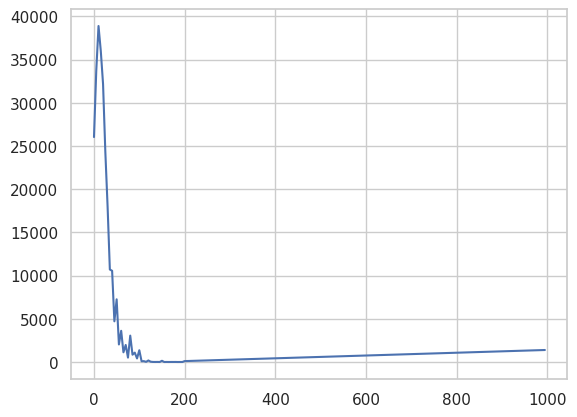

In [16]:
train_values_base['age'].value_counts().sort_index().plot()

<AxesSubplot:>

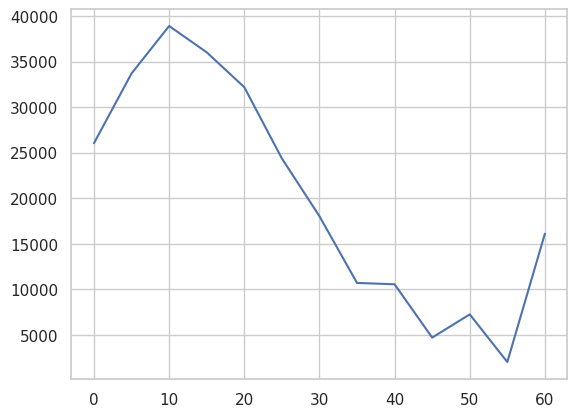

In [17]:
#El valor 60 es un buen valor para que sea el máximo. Más alla de 60 se considera antigua.
age_winsorized = winsorize(train_values_base['age'],(0,0.06))
columna_age_w = pd.Series(np.ma.filled(age_winsorized))
columna_age_w.value_counts().sort_index().plot()

<AxesSubplot:>

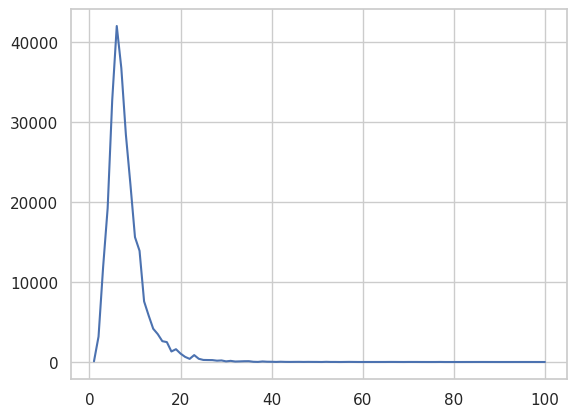

In [18]:
train_values_base['area_percentage'].value_counts().sort_index().plot()

<AxesSubplot:>

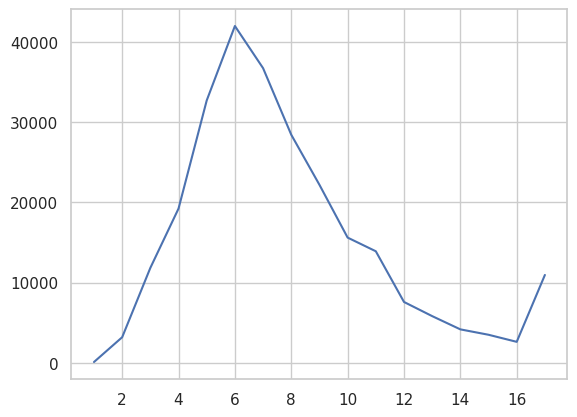

In [19]:
# A la vista, quiero que el máximo sea 12 porque a partir de ese valor empieza a decrecer más lento. 
# También puede ser 20 pero lo sigue dejando poco distruido. Elijo 16 (el promedio) que se alcanza on percentile 0.05 
area_percentage_winsorized = winsorize(train_values_base['area_percentage'],(0,0.04))
columna_area_percentage_w = pd.Series(np.ma.filled(area_percentage_winsorized))
columna_area_percentage_w.value_counts().sort_index().plot()

<AxesSubplot:>

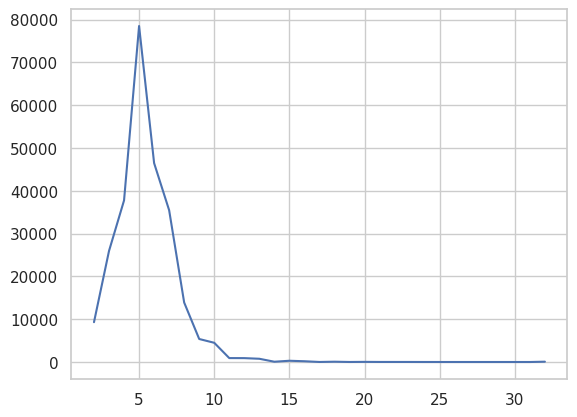

In [20]:
train_values_base['height_percentage'].value_counts().sort_index().plot()

<AxesSubplot:>

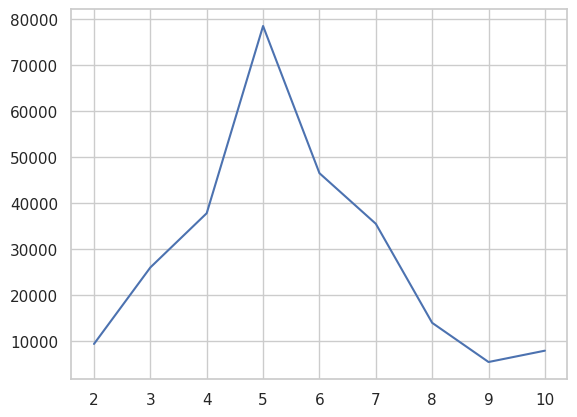

In [21]:
#Percentile 5 más alto.
height_percentage_winsorized = winsorize(train_values_base['height_percentage'],(0,0.03))
columna_height_percentage_w = pd.Series(np.ma.filled(height_percentage_winsorized))
columna_height_percentage_w.value_counts().sort_index().plot()

Probamos el algoritmo con este data set base

In [8]:
# for combining the preprocess with model training
from sklearn.pipeline import Pipeline

# for optimizing the hyperparameters of the pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import FeatureUnion

In [9]:
class DataframeFunctionTransformer():
    def __init__(self, func):
        self.func = func

    def transform(self, input_df, **transform_params):
        return self.func(input_df)

    def fit(self, X, y=None, **fit_params):
        return self

# this function takes a dataframe as input and
# returns a modified version thereof
def select_columns_iloc(input_df,range_columns):
    output_df = input_df.iloc[:,range_columns[0]:range_columns[1]]
    return output_df

def drop_columns(input_df,columns):
    output_df = input_df.copy()
    for column_name in columns:
        output_df = output_df.drop(labels=column_name,axis=1)
    return output_df

def winsorize_columns(input_df,columns_to_winsorize,ranges_winsorize):
    for i in range(len(columns_to_winsorize)):
        columna_winsorize = winsorize(input_df[columns_to_winsorize[i]],ranges_winsorize[i])
        input_df[columns_to_winsorize[i]] = columna_winsorize
    return input_df

def get_dummies_transform(input_df):
    return pd.get_dummies(input_df)

def agregar_col_daño_grave_por_localizacion(input_df,labels_df,col_name_geo):
    """Agrega una columna llamada mean_damage_'col_name_geo'"""
    work_df = input_df[[col_name_geo]].copy()
    work_df = work_df.join(labels_df,on='building_id',how='inner')
    work_df['count_high_damage'] = work_df['damage_grade'] == 3
    input_df['mean_damage_'+col_name_geo] = work_df.groupby(col_name_geo).transform('mean')['count_high_damage']
    return input_df


In [10]:
pipeline_inicial = Pipeline([
    ("drop_has_sec_variants", FunctionTransformer(select_columns_iloc,kw_args={'range_columns':(0,28)})),
    ("drop_plan_config", FunctionTransformer(drop_columns,kw_args={'columns': ['plan_configuration']})),
    ("winsorize", FunctionTransformer(winsorize_columns,kw_args={'columns_to_winsorize': ['age','area_percentage','height_percentage'],
                                                                'ranges_winsorize': [(0,0.03),(0,0.03),(0,0.06)]})),
])


In [11]:
pipeline_daños = Pipeline([
    ("add_high_damage_mean1", FunctionTransformer(agregar_col_daño_grave_por_localizacion,
                                                    kw_args={'labels_df': train_labels,
                                                                'col_name_geo': 'geo_level_1_id'})),
    ("add_high_damage_mean2", FunctionTransformer(agregar_col_daño_grave_por_localizacion,
                                                    kw_args={'labels_df': train_labels,
                                                                'col_name_geo': 'geo_level_2_id'})),
    ("add_high_damage_mean3", FunctionTransformer(agregar_col_daño_grave_por_localizacion,
                                                    kw_args={'labels_df': train_labels,
                                                                'col_name_geo': 'geo_level_3_id'}))
])

In [12]:
train_values_transformado = pipeline_inicial.fit_transform(train_values)

In [13]:
train_values_transformado = pipeline_daños.fit_transform(train_values_transformado)

In [36]:
train_values_transformado = pd.get_dummies(train_values_transformado)

In [37]:
train_values_transformado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 51 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   geo_level_1_id                          260601 non-null  int16  
 1   geo_level_2_id                          260601 non-null  int16  
 2   geo_level_3_id                          260601 non-null  int16  
 3   count_floors_pre_eq                     260601 non-null  int16  
 4   age                                     260601 non-null  int16  
 5   area_percentage                         260601 non-null  int16  
 6   height_percentage                       260601 non-null  int16  
 7   has_superstructure_adobe_mud            260601 non-null  bool   
 8   has_superstructure_mud_mortar_stone     260601 non-null  bool   
 9   has_superstructure_stone_flag           260601 non-null  bool   
 10  has_superstructure_cement_mortar_stone 

XGBoost

In [38]:
#train_values_transformado['age'].value_counts().sort_index().plot()
#train_values_transformado['area_percentage'].value_counts().sort_index().plot()
#train_values_transformado['height_percentage'].value_counts().sort_index().plot()

In [39]:
import xgboost as xgb
import time

In [40]:
## Objective: mult:softprob. Es una softmax (clasificación de mas de 2 clases, como en este caso que hay 3 daños)
## Learning_rate: un valor alto puede saltearse en óptimo y uno muy bajo puede quedarse atrapado en un mínimo local
## XGBoost usa todos los nucleos (njobs=-1) por defecto
xgb_model = xgb.XGBClassifier(objective="multi:softmax",eval_metric='mlogloss',random_state=99)

In [41]:
start_time = time.time()
train_values_subset = train_values_transformado
xgb_model.fit(train_values_subset,train_labels.values.ravel() )
print("--- Duración: %s segundos ---" % (time.time() - start_time))

--- Duración: 57.745835304260254 segundos ---


In [42]:
from sklearn.metrics import f1_score
y_pred = xgb_model.predict(train_values_subset)
f1_score(train_labels, y_pred, average='micro')

0.7690031887828519

**Pruebas raras**:
* Si tiene la misma cantidad de columnas con el cual se entrenó el algoritmo -> lo va a predecir (Ojo)  

Registro de scores (random_state = 99, con objective=multi:softmax y eval_metric= mlogloss sin nada más):  
**GENERALES**
* Con todos los features y one-hot-encoding -> 0.7442
* Con todos los features (OHE) y normalización (StandardScaler) -> 0.7452
* Con todos los features (OHE) y normalización (MinMaxScaler) -> 0.7452  



**Eliminación de columnas**  
* Sin plan_configuration : 0.7447
* Sin has_secondary específicos y sin plan_configuration : Score: 0.7467 Score Test: 0.7304
* Sin has_secondary (ninguno) -> 0.7440
* Sin plan configuration -> 0.7442
* Sin has_secondary (ninguno) y sin legal_ownership_status-> 0.7437
* Sin has_secondary específicos -> 0.743922
* Sin has_secondary específicos y sin plan configuration ->0.7456
* Lo mismo que el anterior pero ahora sin plan_configuration -> 0.7412  

**Sin has_secondary específicos ni plan_configuration- Objetivo>0.7467** (Mejorar no hacer nada):  
* Con winsorizing para age:0.05 , area_percentage:0.06 , height_percentage:0.02. Score entr:0.7457
* Con winsorizing para age:0.01 , area_percentage:0.06 , height_percentage:0.02. Score entr:0.7454 -> legal_ownership_status
* Con winsorizing para age:0.03 , area_percentage:0.03 , height_percentage:0.06. Score entr:0.7473 Score Test:0.7307

**Pruebo sin sacar columnas**
* Con winsorizing para age:0.03 , area_percentage:0.03 , height_percentage:0.06. Score entr:0.7448

**Target encoding high_damage**
* geo_level_1_id -> score:0.7463
* geo_level_2_id -> score:0.7529
* geo_level_3_id -> score:0.7689
* geo_level_1_id + geo_level_2_id: 0.7531
* geo_level_1_id + geo_level_2_id + geo_level_3_id: 0.7690


## Predecir el set de test de DrivenData

Tenemos que predecir nuevos valores de los que desconocemos sus labels o daños.  
Solo tenemos sus columnas o features. Vamos a utilizar nuestro modelo para predecir.

In [27]:
test_values = pd.read_csv('datos/test_values.csv', index_col='building_id')

In [51]:
test_values.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86868 entries, 300051 to 501372
Data columns (total 38 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   geo_level_1_id                          86868 non-null  int64 
 1   geo_level_2_id                          86868 non-null  int64 
 2   geo_level_3_id                          86868 non-null  int64 
 3   count_floors_pre_eq                     86868 non-null  int64 
 4   age                                     86868 non-null  int64 
 5   area_percentage                         86868 non-null  int64 
 6   height_percentage                       86868 non-null  int64 
 7   land_surface_condition                  86868 non-null  object
 8   foundation_type                         86868 non-null  object
 9   roof_type                               86868 non-null  object
 10  ground_floor_type                       86868 non-null  object
 

El set de test tiene que tener el MISMO formato que usamos para entrenar.  
Es decir, si le hicimos algunas modificaciones en las columnas al set de entrenamiento, también tenemos que hacerlas al set de test.  
En este caso, solo seleccionamos algunas columnas y utilizamos One-Hot-Encoding para las variables categóricas (sget_dummies)

Trasformar el set de test

In [76]:
## Solo para un caso de los que hice.. según la modificación se tiene que transformar..
test_values_subset = pipeline_inicial.fit_transform(test_values)

In [77]:
## Agrego a mano las columnas  mean_damage_geo_level_i_id , i=1,2,3
def agregar_columna_mean_damage(input_df,column_name,train_values,train_labels):
    df = train_values.copy()
    df = df[[column_name]]
    df = df.join(train_labels,on='building_id',how='inner')
    df['count_high_damage'] = df['damage_grade'] == 3
    ## Df tiene una columna donde es 1 si el daño es de grado 3.
    mean_damage = df.groupby(column_name).agg('mean')[['count_high_damage']]
    ## mean damage es un df con indice 'column_name' y como unica columna 'count_high_damage'
    output_df = input_df.join(mean_damage,on=column_name,how='left',)
    output_df = output_df.rename(columns={'count_high_damage': 'mean_damage_'+column_name})
    return output_df

In [78]:
test_values_subset = agregar_columna_mean_damage(test_values_subset,'geo_level_1_id',train_values,train_labels)

In [79]:
test_values_subset = agregar_columna_mean_damage(test_values_subset,'geo_level_2_id',train_values,train_labels)

In [80]:
test_values_subset = agregar_columna_mean_damage(test_values_subset,'geo_level_3_id',train_values,train_labels)

In [81]:
mean_global_geo2 = test_values_subset['mean_damage_geo_level_2_id'].mean()
test_values_subset['mean_damage_geo_level_2_id'] = test_values_subset['mean_damage_geo_level_2_id'].fillna(value=mean_global_geo2)
test_values_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86868 entries, 300051 to 501372
Data columns (total 30 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   geo_level_1_id                          86868 non-null  int64  
 1   geo_level_2_id                          86868 non-null  int64  
 2   geo_level_3_id                          86868 non-null  int64  
 3   count_floors_pre_eq                     86868 non-null  int64  
 4   age                                     86868 non-null  int64  
 5   area_percentage                         86868 non-null  int64  
 6   height_percentage                       86868 non-null  int64  
 7   land_surface_condition                  86868 non-null  object 
 8   foundation_type                         86868 non-null  object 
 9   roof_type                               86868 non-null  object 
 10  ground_floor_type                       86868 non-nu

In [82]:
mean_global_geo3 = test_values_subset['mean_damage_geo_level_3_id'].mean()
test_values_subset['mean_damage_geo_level_3_id'] = test_values_subset['mean_damage_geo_level_3_id'].fillna(value=mean_global_geo3)
test_values_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86868 entries, 300051 to 501372
Data columns (total 30 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   geo_level_1_id                          86868 non-null  int64  
 1   geo_level_2_id                          86868 non-null  int64  
 2   geo_level_3_id                          86868 non-null  int64  
 3   count_floors_pre_eq                     86868 non-null  int64  
 4   age                                     86868 non-null  int64  
 5   area_percentage                         86868 non-null  int64  
 6   height_percentage                       86868 non-null  int64  
 7   land_surface_condition                  86868 non-null  object 
 8   foundation_type                         86868 non-null  object 
 9   roof_type                               86868 non-null  object 
 10  ground_floor_type                       86868 non-nu

Predecimos con gs.predict. Le pasamos los valores del set de test.

In [83]:
test_values_subset = pd.get_dummies(test_values_subset)

In [84]:
test_values_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86868 entries, 300051 to 501372
Data columns (total 51 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   geo_level_1_id                          86868 non-null  int64  
 1   geo_level_2_id                          86868 non-null  int64  
 2   geo_level_3_id                          86868 non-null  int64  
 3   count_floors_pre_eq                     86868 non-null  int64  
 4   age                                     86868 non-null  int64  
 5   area_percentage                         86868 non-null  int64  
 6   height_percentage                       86868 non-null  int64  
 7   has_superstructure_adobe_mud            86868 non-null  int64  
 8   has_superstructure_mud_mortar_stone     86868 non-null  int64  
 9   has_superstructure_stone_flag           86868 non-null  int64  
 10  has_superstructure_cement_mortar_stone  86868 non-nu

In [85]:
predictions = xgb_model.predict(test_values_subset)

Guardamos el submit. Lo pasamos a Pandas y de ahí a CSV (por tema de formato).  
Esto es lo que se sube a la página de DrivenData

In [86]:
submission_format = pd.read_csv('datos/submission_format.csv', index_col='building_id')

In [87]:
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [88]:
my_submission.head()

,damage_grade
building_id,
300051,3
99355,2
890251,3
745817,1
421793,3


In [89]:
# Cambiar el nombre al submission para comparar resultados es buena idea..
my_submission.to_csv('submissions/last_submission.csv')

Una mirada adentro del csv

In [90]:
!head 'submissions/last_submission.csv'

building_id,damage_grade
300051,3
99355,2
890251,3
745817,1
421793,3
871976,2
691228,1
896100,3
343471,2


In [42]:
df1 = pd.read_csv('submissions/submission1.csv', index_col='building_id')
df2 = pd.read_csv('submissions/submission2.csv', index_col='building_id')

In [43]:
dict1 = df1.to_dict()['damage_grade']
dict2 = df2.to_dict()['damage_grade']
set1 = set(dict1.items())
set2 = set(dict2.items())
building_ids_difference = (set1 ^ set2)
building_ids_difference = [edificio_daño[0] for edificio_daño in building_ids_difference]
x1 = df1.loc[df1.index.isin(building_ids_difference),:]
x2 = df2.loc[df1.index.isin(building_ids_difference),:]
x1.join(x2,on='building_id',lsuffix='_submission1', rsuffix='_submission2')

,damage_grade_submission1,damage_grade_submission2
building_id,,
745817,1,2
517764,2,1
65760,2,3
127674,3,2
992040,2,3
...,...,...
392512,2,3
594092,2,1
660885,1,2


## Mean encoding geo_level_id_1

In [6]:
df = train_values.copy()
df = df[['geo_level_1_id']]
df = df.join(train_labels,on='building_id',how='inner')
df['count_high_damage'] = df['damage_grade'] == 3
df

,geo_level_1_id,damage_grade,count_high_damage
building_id,,,
802906,6,3,True
28830,8,2,False
94947,21,3,True
590882,22,2,False
201944,11,3,True
...,...,...,...
688636,25,2,False
669485,17,3,True
602512,17,3,True


In [29]:
mean_damage = df.groupby('geo_level_1_id').agg('mean')[['count_high_damage']]
mean_damage

,count_high_damage
geo_level_1_id,
0,0.15
1,0.11
2,0.25
3,0.36
4,0.20
5,0.09
6,0.25
7,0.35
8,0.52


In [13]:
df2 = test_values.copy()

In [14]:
df2

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
300051,17,596,11307,3,20,7,6,t,r,n,...,0,0,0,0,0,0,0,0,0,0
99355,6,141,11987,2,25,13,5,t,r,n,...,1,0,0,0,0,0,0,0,0,0
890251,22,19,10044,2,5,4,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
745817,26,39,633,1,0,19,3,t,r,x,...,0,0,1,0,0,0,0,0,0,0
421793,17,289,7970,3,15,8,7,t,r,q,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310028,4,605,3623,3,70,20,6,t,r,q,...,1,0,0,0,0,0,0,0,0,0
663567,10,1407,11907,3,25,6,7,n,r,n,...,0,0,0,0,0,0,0,0,0,0
1049160,22,1136,7712,1,50,3,3,t,r,n,...,0,0,0,0,0,0,0,0,0,0


In [28]:
df2.join(mean_damage,on='geo_level_1_id',how='inner').sample(20)[['geo_level_1_id','count_high_damage']]

,geo_level_1_id,count_high_damage
building_id,,
691580,20,0.12
93921,20,0.12
473664,28,0.41
17666,20,0.12
737174,20,0.12
549084,25,0.14
711641,4,0.20
441357,27,0.48
415271,20,0.12


In [29]:
df.groupby('geo_level_1_id').transform('mean')

,damage_grade,count_high_damage
building_id,,
802906,2.16,0.25
28830,2.49,0.52
94947,2.56,0.58
590882,2.00,0.13
201944,2.34,0.38
...,...,...
688636,2.05,0.14
669485,2.79,0.81
602512,2.79,0.81


In [30]:
df['mean_high_damage'] = df.groupby('geo_level_1_id').transform('mean')['count_high_damage']

In [31]:
df

,geo_level_1_id,damage_grade,count_high_damage,mean_high_damage
building_id,,,,
802906,6,3,True,0.25
28830,8,2,False,0.52
94947,21,3,True,0.58
590882,22,2,False,0.13
201944,11,3,True,0.38
...,...,...,...,...
688636,25,2,False,0.14
669485,17,3,True,0.81
602512,17,3,True,0.81
